# MQTT

- MQTT (Message Queue Telemetry Transport)
- 為M2M, IOT設計的協定，基於TCP socket，主要是想讓系統資源較低的設備也可以把資料上傳到Server。
- 目前已是ISO的一員:
    - 2016, MQTT is now an ISO standard (ISO/IEC 20922)
- 本次教學中的MQTT雲端服務為Eclipse所提供：iot.eclipse.org    
- 架構如下：
    - 有興趣可以參考此[文章](https://www.javacodegeeks.com/2016/10/mqtt-protocol-tutorial.html)進一步了解
![mqtt](https://www.javacodegeeks.com/wp-content/uploads/2016/10/mqtt_publisher_subscriber-1.png)


# 利用手機和你的IOT設備互動


----
## 圖文併茂的Android手機監控APP - Linear MQTT Dashboard

* 先在android play上安裝Linear MQTT Dashboard
* 打開APP後的操作流程如下圖：
    * Led燈：malo-iot/light
    * 溫度：malo-iot/T
    * 溼度：malo-iot/H
    
![linear-mqtt1](image/linear-mqtt.png)

### 有資訊push上來後的畫面

![linear-mqtt1](image/linear-mqtt2.png)

### 把MQTT資訊送上Server(broker)

In [4]:
# push mqtt msg

import paho.mqtt.client as mqtt
import time, json, datetime, sys, os
import random

def on_connect(client, userdata, flags, rc):
    m="Connected flags"+str(flags)+", result code "+str(rc)+", client_id  "+str(client)
    print(m)

# some online free broker:
#   iot.eclipse.org
#   test.mosquitto.org
#   broker.hivemq.com
broker_address = "broker.hivemq.com"
broker_port = 1883

client1 = mqtt.Client()    #create new instance
client1.on_connect = on_connect        #attach function to callback

time.sleep(0.5)
client1.connect(host=broker_address, port=broker_port, keepalive=60)      #connect to broker
topic_str = '/csu2021/temp'
        
client1.loop_start()    #start the loop
time.sleep(0.5)
print("loop start")

#-- start to push data
for k in range(10):
    temp = 25 + random.randint(-3, 3)
    print('--> push', topic_str, temp)
    client1.publish(topic_str, temp, qos=1)
    time.sleep(5)

time.sleep(0.1)

client1.disconnect()


In [6]:
mqtt_push_data(30)

Connected flags{'session present': 0}, result code 0, client_id  <paho.mqtt.client.Client object at 0x0000020E29ECFC18>
loop start
--> push /malo/home/t1 30


### 練習題：撰寫迴圈，連續送出5個25~35之間的亂數作為溫度值

## 接收資料的方法: subscribe

In [1]:
import paho.mqtt.client as mqtt
import time, json, datetime, sys, os

#==================
#== MQTT Functions

# 當地端程式連線伺服器得到回應時，要做的動作
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    # 將訂閱主題寫在on_connet中
    # 如果我們失去連線或重新連線時 
    # 地端程式將會重新訂閱
    client.subscribe('/csu2021/temp')
    

# 當接收到從伺服器發送的訊息時要進行的動作
def on_message(client, userdata, msg):
    # 轉換編碼utf-8才看得懂中文
    try:
        topic = msg.topic
        value = msg.payload.decode('utf-8')
        dtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print('(topic, value)=(%s, %s) @%s' %(topic, value, dtime))
    except Exception as e:
        print('read data exception: ', str(e))

def run_mqtt():
    try:
        # 連線設定
        # 初始化地端程式
        client = mqtt.Client()

        # 設定連線的動作
        client.on_connect = on_connect

        # 設定接收訊息的動作
        client.on_message = on_message

        # 設定登入帳號密碼
        #client.username_pw_set("try","xxxx")

        # 設定連線資訊(IP, Port, 連線時間)
        client.connect("broker.hivemq.com", 1883, 60)

        # 開始連線，執行設定的動作和處理重新連線問題
        # 也可以手動使用其他loop函式來進行連接
        #client.loop_forever()
        client.loop_start()    #start the loop

        time.sleep(30)

        client.disconnect() # disconnect gracefully
        client.loop_stop() # stops network loop
        
    except Exception as e:
        print('run mqtt error: ', str(e))

run_mqtt()


Connected with result code 0
(topic, value)=(/csu2021/temp, 23) @2021-10-22 10:38:24
(topic, value)=(/csu2021/temp, 23) @2021-10-22 10:38:29
(topic, value)=(/csu2021/temp, 23) @2021-10-22 10:38:33
(topic, value)=(/csu2021/temp, 26) @2021-10-22 10:38:38
(topic, value)=(/csu2021/temp, 25) @2021-10-22 10:38:43
(topic, value)=(/csu2021/temp, 28) @2021-10-22 10:38:48


## 進一步把資料記錄到變數中

In [1]:
import paho.mqtt.client as mqtt
import time, json, datetime, sys, os

temp_list = []
#==================
#== MQTT Functions

# 當地端程式連線伺服器得到回應時，要做的動作
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    # 將訂閱主題寫在on_connet中
    # 如果我們失去連線或重新連線時 
    # 地端程式將會重新訂閱
    client.subscribe('/csu2021/temp')
    

# 當接收到從伺服器發送的訊息時要進行的動作
def on_message(client, userdata, msg):
    # 轉換編碼utf-8才看得懂中文
    try:
        topic = msg.topic
        value = msg.payload.decode('utf-8')
        dtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print('(topic, value)=(%s, %s) @%s' %(topic, value, dtime))
        temp_list.append(value)

    except Exception as e:
        print('read data exception: ', str(e))

def run_mqtt():
    try:
        # 連線設定
        # 初始化地端程式
        client = mqtt.Client()

        # 設定連線的動作
        client.on_connect = on_connect

        # 設定接收訊息的動作
        client.on_message = on_message

        # 設定登入帳號密碼
        #client.username_pw_set("try","xxxx")

        # 設定連線資訊(IP, Port, 連線時間)
        client.connect("broker.hivemq.com", 1883, 60)

        # 開始連線，執行設定的動作和處理重新連線問題
        # 也可以手動使用其他loop函式來進行連接
        #client.loop_forever()
        client.loop_start()    #start the loop

        time.sleep(30)

        client.disconnect() # disconnect gracefully
        client.loop_stop() # stops network loop
        
    except Exception as e:
        print('run mqtt error: ', str(e))

run_mqtt()

print(temp_list)


Connected with result code 0
(topic, value)=(/csu2021/temp, 28) @2021-10-22 10:49:32
(topic, value)=(/csu2021/temp, 28) @2021-10-22 10:49:37
(topic, value)=(/csu2021/temp, 26) @2021-10-22 10:49:42
(topic, value)=(/csu2021/temp, 27) @2021-10-22 10:49:47
(topic, value)=(/csu2021/temp, 26) @2021-10-22 10:49:52
['28', '28', '26', '27', '26']


### 來畫個趨勢圖!

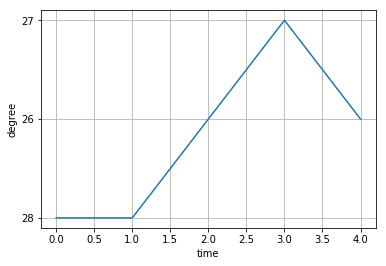

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(temp_list)
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()

## 加入時間的記錄

In [4]:
import paho.mqtt.client as mqtt
import time, json, datetime, sys, os

temp_list = []
time_list = []
#==================
#== MQTT Functions

# 當地端程式連線伺服器得到回應時，要做的動作
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    # 將訂閱主題寫在on_connet中
    # 如果我們失去連線或重新連線時 
    # 地端程式將會重新訂閱
    client.subscribe('/csu2021/temp')
    

# 當接收到從伺服器發送的訊息時要進行的動作
def on_message(client, userdata, msg):
    # 轉換編碼utf-8才看得懂中文
    try:
        topic = msg.topic
        value = msg.payload.decode('utf-8')
        dtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print('(topic, value)=(%s, %s) @%s' %(topic, value, dtime))
        temp_list.append(value)
        time_list.append(dtime)

    except Exception as e:
        print('read data exception: ', str(e))

def run_mqtt():
    try:
        # 連線設定
        # 初始化地端程式
        client = mqtt.Client()

        # 設定連線的動作
        client.on_connect = on_connect

        # 設定接收訊息的動作
        client.on_message = on_message

        # 設定登入帳號密碼
        #client.username_pw_set("try","xxxx")

        # 設定連線資訊(IP, Port, 連線時間)
        client.connect("broker.hivemq.com", 1883, 60)

        # 開始連線，執行設定的動作和處理重新連線問題
        # 也可以手動使用其他loop函式來進行連接
        #client.loop_forever()
        client.loop_start()    #start the loop

        time.sleep(30)

        client.disconnect() # disconnect gracefully
        client.loop_stop() # stops network loop
        
    except Exception as e:
        print('run mqtt error: ', str(e))

run_mqtt()

print(temp_list)
print(time_list)


Connected with result code 0
(topic, value)=(/csu2021/temp, 23) @2021-10-22 10:53:14
(topic, value)=(/csu2021/temp, 25) @2021-10-22 10:53:19
(topic, value)=(/csu2021/temp, 27) @2021-10-22 10:53:24
(topic, value)=(/csu2021/temp, 24) @2021-10-22 10:53:29
(topic, value)=(/csu2021/temp, 25) @2021-10-22 10:53:34
(topic, value)=(/csu2021/temp, 22) @2021-10-22 10:53:39
['23', '25', '27', '24', '25', '22']
['2021-10-22 10:53:14', '2021-10-22 10:53:19', '2021-10-22 10:53:24', '2021-10-22 10:53:29', '2021-10-22 10:53:34', '2021-10-22 10:53:39']


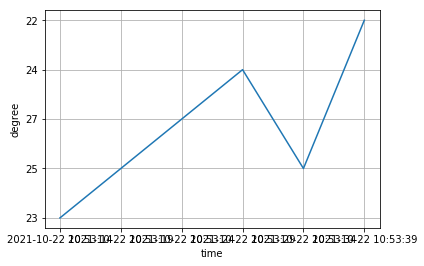

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(time_list, temp_list)
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()

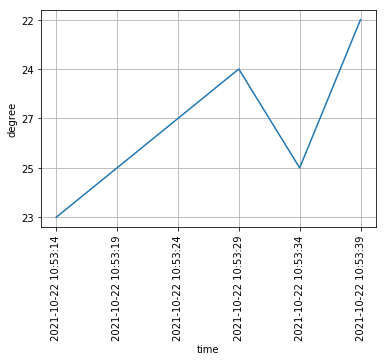

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(time_list, temp_list)
plt.xlabel('time')
plt.ylabel('degree')
plt.xticks(time_list, rotation=90)
plt.grid()

## TODO: 超出上限30度時，發出line警報